<a href="https://colab.research.google.com/github/ashrarhussain97-crypto/Smoke-and-Fire-Detection/blob/main/yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# ===== QUICK FIX FOR PATH ERROR =====

import yaml
import os

# 1. UPDATE THIS TO YOUR ACTUAL DATASET PATH
dataset_dir = '/content/drive/MyDrive/fire_dataset/fire_data_yolo'

print("Fixing data.yaml paths...")

# 2. Check what you have
print(f"\nChecking: {dataset_dir}")

# Check if directories exist
for split in ['train', 'valid', 'val', 'test']:
    path = os.path.join(dataset_dir, split)
    if os.path.exists(path):
        print(f"  ✓ Found: {split}/")

# 3. Create correct data.yaml
val_folder = 'valid' if os.path.exists(os.path.join(dataset_dir, 'valid')) else 'val'

config = {
    'path': os.path.abspath(dataset_dir),
    'train': 'train/images', # Corrected relative path
    'val': f'{val_folder}/images', # Corrected relative path
    'test': 'test/images', # Corrected relative path
    'names': {
        0: 'fire',
        1: 'smoke'
    },
    'nc': 2
}

# 4. Save corrected data.yaml
yaml_path = os.path.join(dataset_dir, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print(f"\n✅ Fixed! New data.yaml:")
print("="*50)
with open(yaml_path, 'r') as f:
    print(f.read())
print("="*50)

# 5. Verify paths exist
print("\n🔍 Verification:")
for key in ['train', 'val', 'test']:
    full_path = os.path.join(config['path'], config[key])
    exists = os.path.exists(full_path)
    if exists:
        num_files = len([f for f in os.listdir(full_path) if f.endswith(('.jpg', '.png'))])
        print(f"  ✓ {key}: {num_files} images at {full_path}")
    else:
        print(f"  ❌ {key}: NOT FOUND at {full_path}")

print("\n✅ Ready to train!")

Fixing data.yaml paths...

Checking: /content/drive/MyDrive/fire_dataset/fire_data_yolo
  ✓ Found: train/
  ✓ Found: valid/
  ✓ Found: test/

✅ Fixed! New data.yaml:
path: /content/drive/MyDrive/fire_dataset/fire_data_yolo
train: train/images
val: valid/images
test: test/images
names:
  0: fire
  1: smoke
nc: 2


🔍 Verification:
  ✓ train: 14122 images at /content/drive/MyDrive/fire_dataset/fire_data_yolo/train/images
  ✓ val: 3099 images at /content/drive/MyDrive/fire_dataset/fire_data_yolo/valid/images
  ✓ test: 4306 images at /content/drive/MyDrive/fire_dataset/fire_data_yolo/test/images

✅ Ready to train!


In [21]:
# ===== TRAIN YOLO WITH CORRECT PATHS =====

from ultralytics import YOLO

# Use the FULL PATH to your corrected data.yaml
yaml_path = '/content/drive/MyDrive/fire_dataset/fire_data_yolo/data.yaml'

# Initialize YOLO from scratch
model = YOLO('yolo11s.yaml')

# Start training
results = model.train(
    data=yaml_path,  # ← Use full path!
    epochs=20,
    imgsz=640,
    batch=16,
    device=0,
    pretrained=False,
    patience=50,
    project='/content/drive/MyDrive/fire_dataset/fire_data_yolo',
    name='fire_yolo_scratch',
    exist_ok=True
)

print("✅ Training started!")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/fire_dataset/fire_data_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=fire_yolo_scratch, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=

Frame 35/50
✓ No fire detected
FPS: 77.8
------------------------------------------------------------


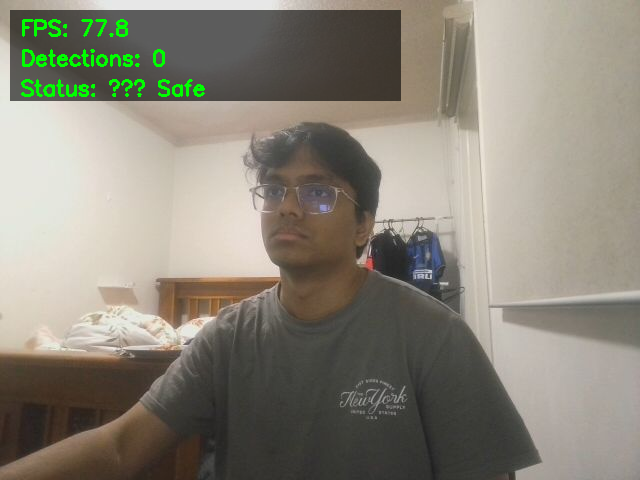

<IPython.core.display.Javascript object>


⚠️  Detection stopped by user

📊 DETECTION SUMMARY
Total frames processed: 35
Total detections: 0
Average FPS: 73.4
Detection rate: 0.0%

✅ Demo complete!


In [ ]:
# ===== LIVE WEBCAM FIRE DETECTION =====
# Real-time detection using your laptop/phone camera
# Run this in Google Colab

"""
SETUP:
1. Run this code in Google Colab
2. Allow camera permissions when prompted
3. Point camera at fire images on screen or real fire (safely!)
4. Press 'Stop' button in Colab to end demo
"""

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode
import cv2
import numpy as np
from ultralytics import YOLO
import time
from IPython.display import clear_output
import io
from PIL import Image as PILImage

# ==================================================
# CONFIGURATION
# ==================================================

CONFIG = {
    'model_path': '/content/drive/MyDrive/fire_dataset/yolo11s_fire_scratch/weights/best.pt',
    'conf_threshold': 0.25,  # Detection confidence threshold
    'camera_quality': 0.8,   # Image quality (0.1-1.0)
    'show_fps': True,
    'show_confidence': True
}

# ==================================================
# LOAD MODEL
# ==================================================

print("Loading model...")
model = YOLO(CONFIG['model_path'])
print("✓ Model loaded!")

# ==================================================
# WEBCAM CAPTURE FUNCTIONS
# ==================================================

def take_photo(quality=0.8):
    """Capture photo from webcam"""
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Wait for video to load
            await new Promise(resolve => setTimeout(resolve, 1000));

            // Capture frame
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            const img = canvas.toDataURL('image/jpeg', quality);

            stream.getVideoTracks()[0].stop();
            div.remove();

            return img;
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    return binary

def process_frame(img_binary, model, config):
    """Process a single frame and detect fire/smoke"""
    # Convert to numpy array
    img = PILImage.open(io.BytesIO(img_binary))
    frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Run detection
    start_time = time.time()
    results = model(frame, conf=config['conf_threshold'], verbose=False)[0]
    inference_time = time.time() - start_time

    # Draw detections
    output = frame.copy()
    detections = []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        conf = float(box.conf[0].cpu().numpy())
        cls = int(box.cls[0].cpu().numpy())
        cls_name = results.names[cls]

        # Color coding
        if cls_name == 'fire':
            color = (0, 0, 255)  # Red
            alert = "🔥 FIRE DETECTED!"
        elif cls_name == 'smoke':
            color = (0, 255, 255)  # Yellow
            alert = "💨 SMOKE DETECTED!"
        else:
            color = (0, 255, 0)
            alert = ""

        # Draw bounding box
        cv2.rectangle(output, (x1, y1), (x2, y2), color, 3)

        # Draw label with background
        label = f"{cls_name}: {conf:.2f}"
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
        cv2.rectangle(output, (x1, y1 - h - 10), (x1 + w, y1), color, -1)
        cv2.putText(output, label, (x1, y1 - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        detections.append({
            'class': cls_name,
            'confidence': conf,
            'bbox': [x1, y1, x2, y2],
            'alert': alert
        })

    # Add info overlay
    fps = 1.0 / inference_time if inference_time > 0 else 0

    # Semi-transparent background for text
    overlay = output.copy()
    cv2.rectangle(overlay, (10, 10), (400, 100), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.6, output, 0.4, 0, output)

    # Add text
    info_text = [
        f"FPS: {fps:.1f}",
        f"Detections: {len(detections)}",
        f"Status: {'🚨 ALERT!' if detections else '✓ Safe'}"
    ]

    y_offset = 35
    for text in info_text:
        cv2.putText(output, text, (20, y_offset),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        y_offset += 30

    # Add alert banner if fire/smoke detected
    if detections:
        for det in detections:
            if det['alert']:
                cv2.rectangle(output, (0, 0), (output.shape[1], 50), (0, 0, 255), -1)
                cv2.putText(output, det['alert'], (20, 35),
                           cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)
                break

    return output, detections, fps

# ==================================================
# CONTINUOUS DETECTION
# ==================================================

def live_detection_continuous(model, config, num_frames=50):
    """
    Continuous webcam detection

    Args:
        model: YOLO model
        config: Configuration dict
        num_frames: Number of frames to process (adjust for longer/shorter demo)
    """
    print("="*60)
    print("🎥 STARTING LIVE FIRE DETECTION")
    print("="*60)
    print("\n📹 Camera will activate shortly...")
    print("⚠️  Point camera at fire images or simulated fire")
    print("💡 This will process ~50 frames (about 1-2 minutes)")
    print("\nProcessing...\n")

    total_detections = 0
    frame_count = 0
    fps_history = []

    try:
        for i in range(num_frames):
            # Capture frame
            img_binary = take_photo(quality=config['camera_quality'])

            # Process frame
            output, detections, fps = process_frame(img_binary, model, config)

            # Update statistics
            frame_count += 1
            total_detections += len(detections)
            fps_history.append(fps)

            # Display result
            clear_output(wait=True)
            print(f"Frame {frame_count}/{num_frames}")
            if detections:
                print("🚨 ALERT: Fire/Smoke Detected!")
                for det in detections:
                    print(f"  - {det['class'].upper()}: {det['confidence']:.2%} confidence")
            else:
                print("✓ No fire detected")
            print(f"FPS: {fps:.1f}")
            print("-"*60)

            # Show image
            cv2_imshow(output)

            # Small delay
            time.sleep(0.1)

    except KeyboardInterrupt:
        print("\n⚠️  Detection stopped by user")

    # Summary
    print("\n" + "="*60)
    print("📊 DETECTION SUMMARY")
    print("="*60)
    print(f"Total frames processed: {frame_count}")
    print(f"Total detections: {total_detections}")
    print(f"Average FPS: {np.mean(fps_history):.1f}")
    print(f"Detection rate: {(total_detections/frame_count)*100:.1f}%")
    print("="*60)

# ==================================================
# SINGLE FRAME DETECTION (For Testing)
# ==================================================

def live_detection_single(model, config):
    """Take single photo and detect"""
    print("📸 Taking photo...")
    img_binary = take_photo(quality=config['camera_quality'])

    print("🔍 Analyzing...")
    output, detections, fps = process_frame(img_binary, model, config)

    print("\n" + "="*60)
    print("🎯 DETECTION RESULTS")
    print("="*60)

    if detections:
        print(f"⚠️  DETECTED: {len(detections)} object(s)")
        for i, det in enumerate(detections, 1):
            print(f"\n{i}. {det['class'].upper()}")
            print(f"   Confidence: {det['confidence']:.2%}")
            print(f"   Location: {det['bbox']}")
    else:
        print("✓ No fire or smoke detected")

    print(f"\nProcessing speed: {fps:.1f} FPS")
    print("="*60)

    # Display result
    cv2_imshow(output)

    return output, detections

# ==================================================
# RUN DETECTION
# ==================================================

if __name__ == '__main__':
    print("\n" + "="*60)
    print("🔥 LIVE FIRE & SMOKE DETECTION SYSTEM")
    print("="*60)
    print("\nChoose mode:")
    print("1. Single shot detection (test)")
    print("2. Continuous detection (full demo)")

    # For demo, use continuous mode
    mode = 2  # Change to 1 for single shot

    if mode == 1:
        print("\n📸 Single Shot Mode")
        output, detections = live_detection_single(model, CONFIG)
    else:
        print("\n📹 Continuous Detection Mode")
        live_detection_continuous(model, CONFIG, num_frames=50)

    print("\n✅ Demo complete!")